# TensorFlow sign language recognizer

___

## Introduction

Until now, we've always used numpy to build neural networks. Now we will use TensorFlow, to speed up machine learning development significantly and to forget about hard low level functions implementations - framework does this for us. 

Our goal in this project is to build an algorithm capable of recognizing a sign with high accuracy. To do so, we are going to build a tensorflow model that is almost the same as one we have previously built in numpy for cat recognition. It's gonna be cool to compary numpy implementation with tf one.

Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) and Placeholders (constants which you can pass on execution) that are not yet executed/evaluated. 
2. Write operations between those Tensors.
3. Initialize your Tensors. 
4. Create a Session. 
5. Run the Session, with specified values for Placeholders. This will run the operations you'd written above. 

This project - is a simple example of neural network, built with tf. Most probably, this notebook cannot help you. This notebook is here just to represent my progress in Maching Learning.

## Imports

* [numpy](https://www.numpy.org/) - for SIMD np.array, and for math.
* [matplotlib](http://matplotlib.org) - for data graphs plotting.
* [tensorflow](https://www.tensorflow.org/) - the framework itself

In [1]:
import math
import h5py
import logging, os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.framework import ops
import tensorflow.python.util.deprecation as deprecation

%matplotlib inline

# I am using old tensorflow functions, and i don't want to see warnings.
deprecation._PRINT_DEPRECATION_WARNINGS = False
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

---

## Defining dataset

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.

<center><img src="images/hands.png" style="width:800px;height:350px;"></img></center>
<center> <u><font color='purple'>Figure 1</font></u></center>

We will load dataset with this function

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Let's use it to load and explore the dataset

y = 5


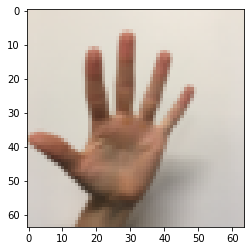

In [3]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Example of a picture
index = 3
plt.imshow(X_train_orig[index])
print (f"y = {str(np.squeeze(Y_train_orig[:, index]))}")

This neural network will output not only 0 and 1, but 0, 1, 2, 3, 4, 5 determining the signs number. For that we will need to implement `convert_to_one_hot` function, which will convert our Y array [4, 3, 2, 1, 5, 3] to one-hot arrray as specified on example below

<img src="images/onehot.png" style="width:600px;height:150px;">

Let's implement `convert_to_one_hot`

In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T

    return Y

As usual we flatten the image dataset, then normalize it by dividing by 255. On top of that, we will convert each label to a one-hot vector as shown in Figure 1.

In [5]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


## Building neural network

### Defining model's architecture

The model is gonna be *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### Initialization

#### Creating placeholders

Firstly, we will need placeholders to pass `X` and `Y` data.

In [6]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    # We are using None because it let's us be flexible on the number of examples you will for the placeholders.
    X = tf.placeholder(tf.float32, (n_x, None))
    Y = tf.placeholder(tf.float32, (n_y, None))
    
    return X, Y

#### Initializing the parameters

As usual we will need to initialize parameters for our model. We are going use Xavier Initialization for weights and Zero Initialization for biases.

In [7]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
        
    W1 = tf.get_variable('W1', [25, 12288], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [25, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12, 25], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6, 12], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [6, 1], initializer=tf.zeros_initializer())

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

### Forward propagation

In [8]:
def forward_propagation(X, parameters):
    """
    Applies the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Actual propagation.                       # numpy equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)           # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                         # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)          # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                         # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)          # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

### Computing cost

We can use `tf.nn.sigmoid_cross_entropy_with_logits`, which computes

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$

Which is actually the cost we implemented by hand in early projects. This is default cost, that's why tf has it's implementation.

In [9]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # To fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Computing actual cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

### Backward propagation and parameter updates

This is where we become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After we compute the cost function, we will create an `optimizer` object. We have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

Just know, that we will use Adam optimizer and we will update parameters as usual. Se, we skip this section, coz it is not needed :)

### Helper functions

We will need some helper functions for our model. Let's not talk about them much - they are pretty common.

- `random_mini_batches` - slices up train array to mini-batches

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 2.6 - Building the model

Now, let's build it all together.

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Teahes a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # Set global variables
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3
    
    # Init variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Define tensors and placeholders
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Init tf global variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as session:
        
        # Run the initialization
        session.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            seed = seed + 1
            
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the graph on a minibatch.
                _ , minibatch_cost = session.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Lets save the parameters in a variable
        parameters = session.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

## Testing

Let's run the following cell to train the model!


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Cost after epoch 0: 1.889086
Cost after epoch 100: 1.604510
Cost after epoch 200: 1.476755
Cost after epoch 300: 1.384896
Cost after epoch 400: 1.309389
Cost after epoch 500: 1.255750
Cost after epoch 600: 1.181962
Cost after epoch 700: 1.131070
Cost after epoch 800: 1.071697
Cost after epoch 900: 1.059483
Cost after epoch 1000: 0.987996
Cost after epoch 1100: 0.958850
Cost after epoch 1200: 0.905426
Cost after epoch 1300: 0.880245
Cost after epoch 1400: 0.858966


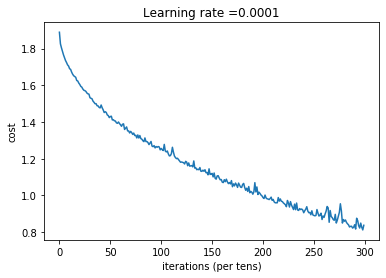

Parameters have been trained!
Train Accuracy: 0.7175926
Test Accuracy: 0.46666667


In [12]:
parameters = model(X_train, Y_train, X_test, Y_test)

Amazing, the algorithm can recognize a sign representing a figure between 0 and 5 with 71.7% accuracy.
It performs worse on test, just because it the data is overfitting and it is, and i don't want to generalize it. I just want to showcase the framework for now. I'll start making **perfect** models, when i'll learn everything. But now, i still have a lot to learn.

My thought on fixing the model:
- Model seems big enough to fit the training set well. However, given the difference between train and test accuracy, we could try to add L2 or dropout regularization to reduce overfitting.

And yes, sorry for warning in the output above. Cannot fix this, and i wanna go next.

## Project analysis

As you can see, tensor flow does two things for us:
- Implements back propagation (which is math heavy)
- Provides a log of reusable and well optimized functions

With it model training is really easy. And yes, i wanted to say, that google anounces TensorFlow 2, which is much better. I'll make a tutorial about it later. :)

---

## Afterword

Thx for an amazing [Coursera course](https://www.coursera.org/learn/neural-networks-deep-learning) from Andrew NG for this assignment. 
I really enjoyed it, and learned a lot from it :)  If you want to learn Machine Learning just like i did - go enroll, it's really fun :)

I Hope, that if you read my code - you enjoyed it too. Thank you and bye!